# 🍷 Wine Type & Quality Prediction — Deep Learning (v2)
**Datasets:** `redwinequality.csv` and `whitewinequality.csv`

**Goal:** Build a high‑quality portfolio project that predicts **wine type** (red vs white) and **wine quality**, with rigorous EDA, baseline models, a Keras deep learning model, and clear evaluation.

## Step‑by‑Step Roadmap
1) Setup & imports
2) Load datasets and merge (add `type` column)
3) EDA: class balance, distributions, correlations (with explanations)
4) Preprocessing: train/val/test split, scaling
5) Baselines: Logistic Regression (type) & RandomForest (quality)
6) Deep Learning: Keras model for **type classification** (and optionally quality)
7) Evaluation: metrics, confusion matrix, ROC‑AUC, learning curves
8) (Optional) Explainability: permutation importance / SHAP
9) Save models + Inference function
10) Results summary to copy into README

### 1) Setup & imports

In [7]:
# If running on Colab/local and missing packages, uncomment:
# !pip install pandas numpy scikit-learn matplotlib seaborn tensorflow shap
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
                             confusion_matrix, classification_report, mean_absolute_error, r2_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

### 2) Load datasets and merge
**Why this matters:** The red/white wine files sometimes use `;` as delimiter. We auto‑detect the delimiter, align columns, add a `type` column, and merge.

In [8]:
RED_PATH = 'redwinequality.csv'
WHITE_PATH = 'whitewinequality.csv'
def load_wine(path):
    # Try comma first, then semicolon
    try:
        df = pd.read_csv(path)
        if df.shape[1] == 1:  # likely wrong delimiter
            df = pd.read_csv(path, sep=';')
    except Exception:
        df = pd.read_csv(path, sep=';')
    return df

red = load_wine(RED_PATH)
white = load_wine(WHITE_PATH)
red['type'] = 'red'
white['type'] = 'white'
df = pd.concat([red, white], ignore_index=True)
print(df.shape)
display(df.head())
display(df.isnull().sum())

(6497, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64

### 3) EDA — distributions, correlations, and class balance
- Inspect basic stats
- Check `quality` distribution and `type` balance
- Correlation heatmap for numeric features
- Compare key features between red and white

,count,mean,std,min,25%,50%,75%,max
fixed acidity,6497.0,7.215307,1.296434,3.80000,6.40000,7.00000,7.70000,15.90000
volatile acidity,6497.0,0.339666,0.164636,0.08000,0.23000,0.29000,0.40000,1.58000
citric acid,6497.0,0.318633,0.145318,0.00000,0.25000,0.31000,0.39000,1.66000
residual sugar,6497.0,5.443235,4.757804,0.60000,1.80000,3.00000,8.10000,65.80000
chlorides,6497.0,0.056034,0.035034,0.00900,0.03800,0.04700,0.06500,0.61100
free sulfur dioxide,6497.0,30.525319,17.749400,1.00000,17.00000,29.00000,41.00000,289.00000
total sulfur dioxide,6497.0,115.744574,56.521855,6.00000,77.00000,118.00000,156.00000,440.00000
density,6497.0,0.994697,0.002999,0.98711,0.99234,0.99489,0.99699,1.03898
pH,6497.0,3.218501,0.160787,2.72000,3.11000,3.21000,3.32000,4.01000
sulphates,6497.0,0.531268,0.148806,0.22000,0.43000,0.51000,0.60000,2.00000



Type balance:
type
white    4898
red      1599
Name: count, dtype: int64

Quality distribution:
quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: count, dtype: int64


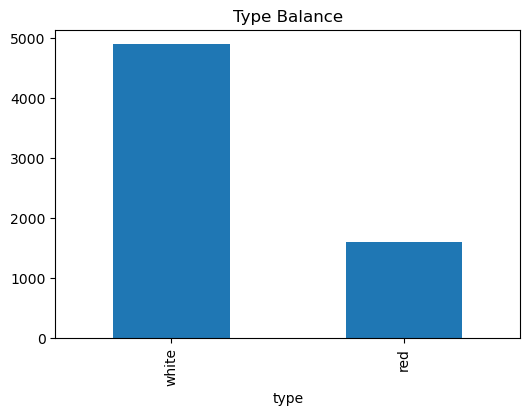

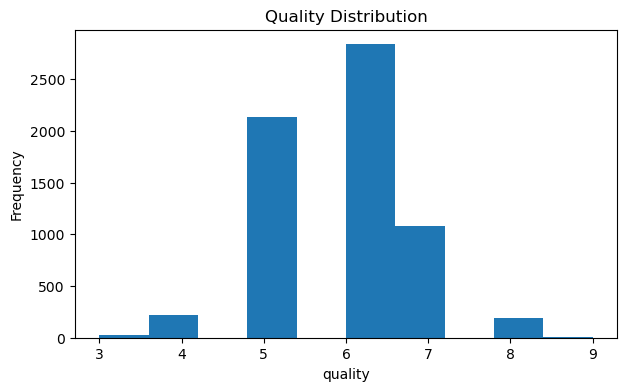

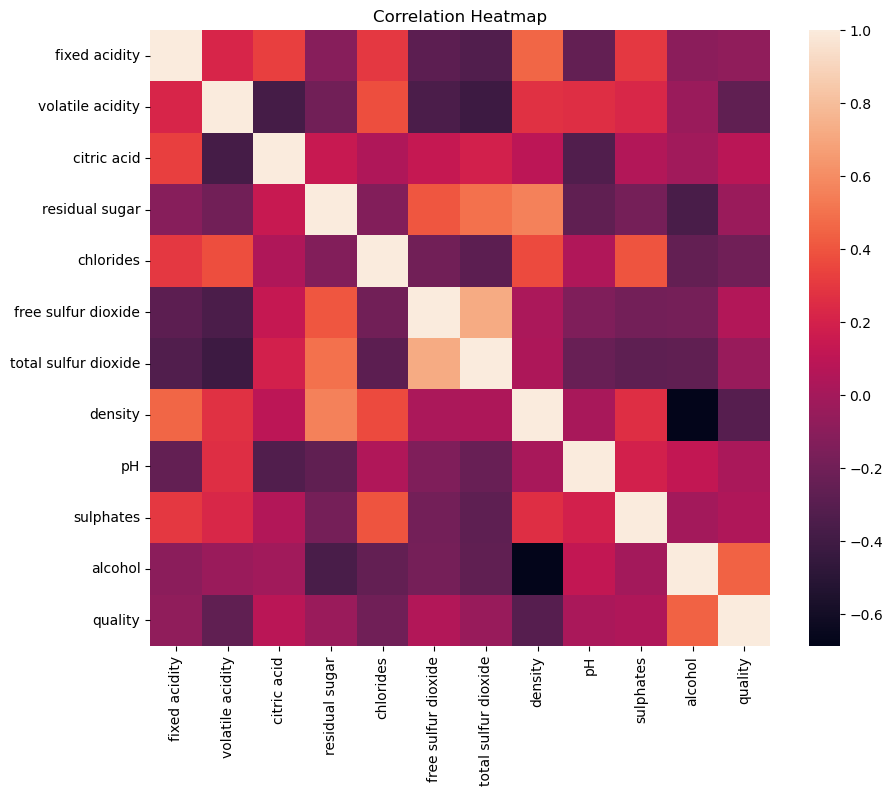

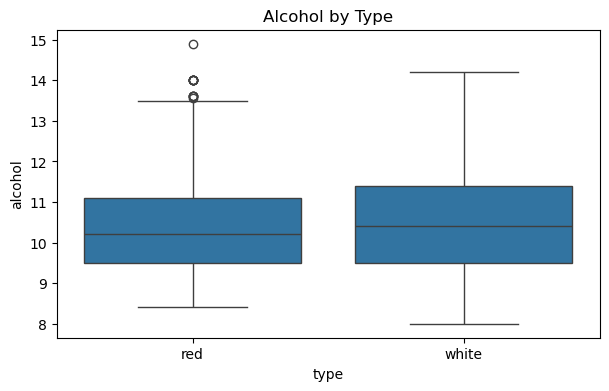

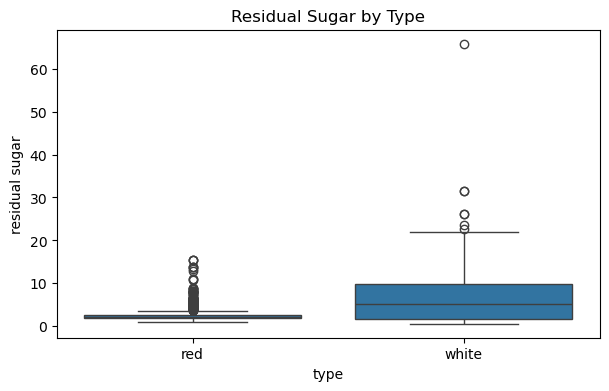

In [9]:
display(df.describe().T)
print('\nType balance:')
print(df['type'].value_counts())
print('\nQuality distribution:')
print(df['quality'].value_counts().sort_index())

plt.figure(figsize=(6,4))
df['type'].value_counts().plot(kind='bar', title='Type Balance'); plt.show()

plt.figure(figsize=(7,4))
df['quality'].plot(kind='hist', bins=10, title='Quality Distribution'); plt.xlabel('quality'); plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df.drop(columns=['type']).corr(), annot=False)
plt.title('Correlation Heatmap'); plt.show()

plt.figure(figsize=(7,4))
sns.boxplot(x='type', y='alcohol', data=df); plt.title('Alcohol by Type'); plt.show()
plt.figure(figsize=(7,4))
sns.boxplot(x='type', y='residual sugar' if 'residual sugar' in df.columns else 'residual_sugar', data=df)
plt.title('Residual Sugar by Type'); plt.show()

### 4) Preprocessing — splits & scaling
**Strategy:**
- For **type classification**: features = all chemistry columns; target = `type` (0=red, 1=white)
- For **quality regression (optional)**: target = `quality`
We standardize features for the neural network.

In [10]:
feature_cols = [c for c in df.columns if c not in ['type','quality']]
X_all = df[feature_cols].copy()
y_type = (df['type'] == 'white').astype(int)  # 1=white, 0=red

# Train/val/test split (stratify by type)
X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_type, test_size=0.3, stratify=y_type, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test)
X_train_sc.shape, X_val_sc.shape, X_test_sc.shape

((4547, 11), (975, 11), (975, 11))

### 5) Baselines
Start simple before deep learning:
- **Logistic Regression** for type classification
- **RandomForestRegressor** for quality (optional)
We’ll compare these to the neural network later.

In [11]:
base_clf = LogisticRegression(max_iter=1000)
base_clf.fit(X_train_sc, y_train)
proba_val_base = base_clf.predict_proba(X_val_sc)[:,1]
pred_val_base = (proba_val_base>=0.5).astype(int)
print('Baseline (LogReg) — Val Acc:', accuracy_score(y_val, pred_val_base))
print('Baseline (LogReg) — Val F1:', f1_score(y_val, pred_val_base))
print('Baseline (LogReg) — Val AUC:', roc_auc_score(y_val, proba_val_base))
print(confusion_matrix(y_val, pred_val_base))
print(classification_report(y_val, pred_val_base))

# Optional: quality regression baseline
if 'quality' in df.columns:
    yq = df.loc[X_train.index.union(X_val.index), 'quality']
    # Align X to those indices
    Xq = df.loc[X_train.index.union(X_val.index), feature_cols]
    Xq_tr = scaler.fit_transform(Xq)  # reuse scaler not strictly needed for trees
    rfq = RandomForestRegressor(random_state=42)
    rfq.fit(Xq_tr[:len(X_train)], df.loc[X_train.index, 'quality'])
    pred_q = rfq.predict(Xq_tr[len(X_train):])
    print('Quality baseline (RF) — MAE:', mean_absolute_error(df.loc[X_val.index,'quality'], pred_q))
    print('Quality baseline (RF) — R2 :', r2_score(df.loc[X_val.index,'quality'], pred_q))

Baseline (LogReg) — Val Acc: 0.9887179487179487
Baseline (LogReg) — Val F1: 0.9925220938137321
Baseline (LogReg) — Val AUC: 0.991609977324263
[[234   6]
 [  5 730]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       240
           1       0.99      0.99      0.99       735

    accuracy                           0.99       975
   macro avg       0.99      0.98      0.98       975
weighted avg       0.99      0.99      0.99       975

Quality baseline (RF) — MAE: 0.6984319539719539
Quality baseline (RF) — R2 : -0.033568542957970626


### 6) Deep Learning — Keras model for type classification
**Design choices:**
- Dense → BatchNorm → ReLU → Dropout (repeat)
- EarlyStopping and ReduceLROnPlateau for stable training
- Binary cross‑entropy, AUC + accuracy metrics

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(42)
inp = keras.Input(shape=(X_train_sc.shape[1],))
x = layers.Dense(64, kernel_regularizer=keras.regularizers.l2(1e-4))(inp)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, kernel_regularizer=keras.regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.2)(x)
out = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inp, out)
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.AUC(name='auc')])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,505 (21.50 KB)

 Trainable params: 5,249 (20.50 KB)

 Non-trainable params: 256 (1.00 KB)

#### Train with callbacks (EarlyStopping + ReduceLROnPlateau)

,accuracy,auc,loss,val_accuracy,val_auc,val_loss,learning_rate
34,0.997361,0.998952,0.018647,0.995897,0.999714,0.021841,0.0005
35,0.998241,0.999375,0.016388,0.995897,0.999700,0.021804,0.0005
36,0.997141,0.999366,0.018133,0.995897,0.999697,0.021708,0.0005
37,0.996041,0.998718,0.021005,0.995897,0.997704,0.022493,0.0005
38,0.996261,0.999806,0.018047,0.995897,0.997698,0.022752,0.0005


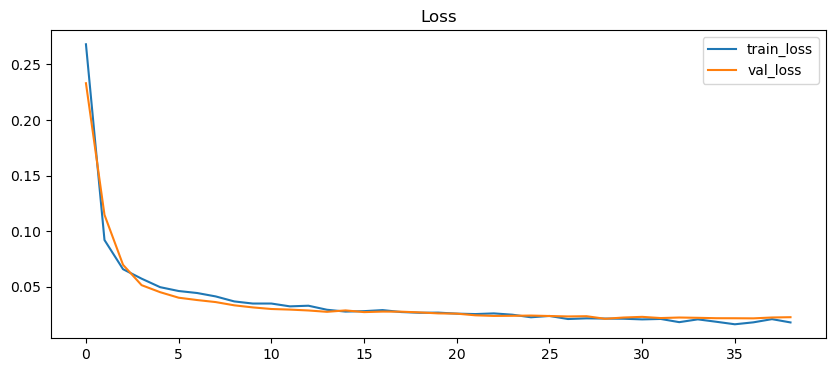

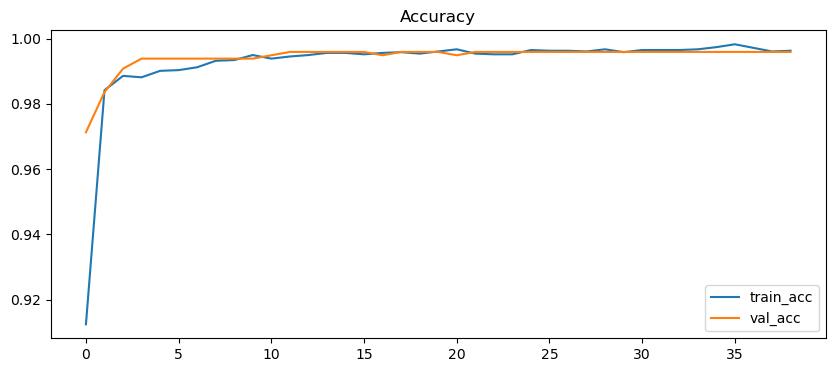

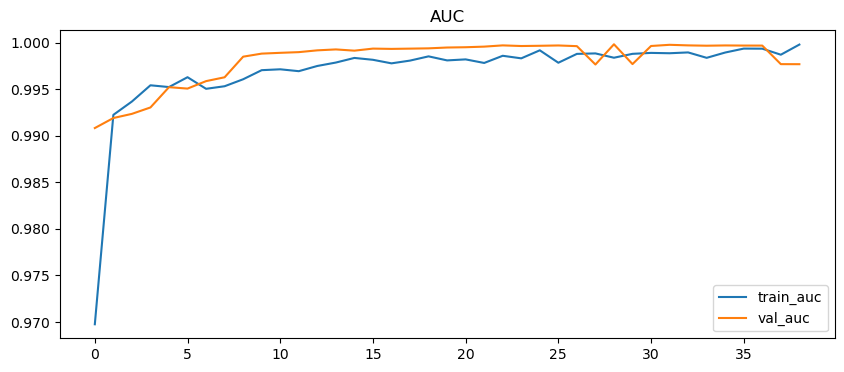

In [18]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_auc', mode='max'),
    keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-5, monitor='val_loss')
]
history = model.fit(X_train_sc, y_train,
                    validation_data=(X_val_sc, y_val),
                    epochs=100, batch_size=64, callbacks=callbacks, verbose=0)
hist = pd.DataFrame(history.history)
display(hist.tail())
plt.figure(figsize=(10,4))
plt.plot(hist['loss'], label='train_loss'); plt.plot(hist['val_loss'], label='val_loss'); plt.legend(); plt.title('Loss'); plt.show()
plt.figure(figsize=(10,4))
plt.plot(hist['accuracy'], label='train_acc'); plt.plot(hist['val_accuracy'], label='val_acc'); plt.legend(); plt.title('Accuracy'); plt.show()
plt.figure(figsize=(10,4))
plt.plot(hist['auc'], label='train_auc'); plt.plot(hist['val_auc'], label='val_auc'); plt.legend(); plt.title('AUC'); plt.show()

#### Validate & Test performance

In [19]:
proba_val_nn = model.predict(X_val_sc).ravel()
pred_val_nn = (proba_val_nn>=0.5).astype(int)
print('NN — Val Acc:', accuracy_score(y_val, pred_val_nn))
print('NN — Val F1 :', f1_score(y_val, pred_val_nn))
print('NN — Val AUC:', roc_auc_score(y_val, proba_val_nn))
print(confusion_matrix(y_val, pred_val_nn))

proba_test_nn = model.predict(X_test_sc).ravel()
pred_test_nn = (proba_test_nn>=0.5).astype(int)
print('NN — Test Acc:', accuracy_score(y_test, pred_test_nn))
print('NN — Test F1 :', f1_score(y_test, pred_test_nn))
print('NN — Test AUC:', roc_auc_score(y_test, proba_test_nn))
print(confusion_matrix(y_test, pred_test_nn))
print(classification_report(y_test, pred_test_nn))

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
NN — Val Acc: 0.9958974358974358
NN — Val F1 : 0.9972826086956522
NN — Val AUC: 0.9998242630385488
[[237   3]
 [  1 734]]
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
NN — Test Acc: 0.9969230769230769
NN — Test F1 : 0.9979577944179714
NN — Test AUC: 0.9966014739229025
[[239   1]
 [  2 733]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       240
           1       1.00      1.00      1.00       735

    accuracy                           1.00       975
   macro avg       1.00      1.00      1.00       975
weighted avg       1.00      1.00      1.00       975



### 7) (Optional) Explainability
Permutation importance on the neural network’s predictions (use with caution; it’s approximate). SHAP for DNNs is heavier; include optionally.

In [20]:
# Optional: permutation importance using validation set
try:
    from sklearn.inspection import permutation_importance
    # Wrap NN predictions into a scikit-learn compatible estimator
    class NNWrapper:
        def __init__(self, model, scaler): self.m, self.sc = model, scaler
        def predict_proba(self, X):
            Xs = self.sc.transform(X)
            p = self.m.predict(Xs, verbose=0).ravel()
            return np.vstack([1-p, p]).T
    nn_est = NNWrapper(model, scaler)
    r = permutation_importance(nn_est, X_val, y_val, n_repeats=10, scoring='roc_auc', random_state=42)
    imp = pd.Series(r.importances_mean, index=X_val.columns).sort_values(ascending=False)[:12]
    display(imp)
except Exception as e:
    print('Permutation importance skipped:', e)

Permutation importance skipped: The 'estimator' parameter of permutation_importance must be an object implementing 'fit'. Got <__main__.NNWrapper object at 0x000001D3D116D550> instead.


### 8) Save model & inference function

In [21]:
model.save('wine_type_model.h5')
import joblib
joblib.dump(scaler, 'wine_scaler.joblib')
print('Saved wine_type_model.h5 and wine_scaler.joblib')

def predict_wine_type(sample_df):
    """sample_df: DataFrame with same feature columns in any order"""
    sample_df = sample_df[feature_cols]
    Xs = scaler.transform(sample_df)
    proba = model.predict(Xs).ravel()
    return pd.DataFrame({'proba_white': proba, 'pred_type': (proba>=0.5).astype(int)})

Saved wine_type_model.h5 and wine_scaler.joblib


### 9) Results Summary — copy into README
- **Baseline (LogReg) Val AUC:** ...  | **Val Acc/F1:** ... / ...
- **NN Val AUC:** ...  | **Val Acc/F1:** ... / ...
- **NN Test AUC:** ... | **Test Acc/F1:** ... / ...
- **Top features (perm. importance):** ...